## Data Preprocessing

In this notebook I will look at the data, clean it and pre process it to ready it for visualisation and forecasting

In [50]:
#importing libraries
import numpy as np
import pandas as pd

from glob import glob
import missingno as msno

In [51]:
#loading data
folder_path = 'csvs_per_year/'

df = pd.DataFrame()

#data is found in different files
#getting data from folder path and concatenating it to the same df
for file_name in glob(folder_path+'*.csv'):
    
    if len(df) == 0:
        df = pd.read_csv(file_name)
    else:
        newdf = pd.read_csv(file_name)
        df = pd.concat([df,newdf])

In [52]:
#converting date to datetime format and sorting 
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date'])

In [53]:
df.head()

,date,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
108376,2001-01-01 01:00:00,NaN,3.62,NaN,NaN,0.79,59.150002,283.899994,NaN,7.440000,40.139999,NaN,23.389999,2.15,NaN,28079018,NaN,NaN,NaN
108384,2001-01-01 01:00:00,3.23,1.25,2.56,4.58,0.24,55.290001,120.000000,2.22,7.830000,30.559999,1.80,22.100000,1.58,10.74,28079099,NaN,NaN,NaN
108383,2001-01-01 01:00:00,2.13,0.87,1.44,3.16,NaN,53.400002,100.000000,1.06,8.350000,36.669998,1.28,11.420000,NaN,7.04,28079025,NaN,NaN,NaN
108382,2001-01-01 01:00:00,0.40,0.79,NaN,2.09,0.14,47.320000,54.950001,1.17,3.400000,14.440000,0.86,9.690000,1.51,5.83,28079024,NaN,NaN,NaN
108381,2001-01-01 01:00:00,1.08,0.67,0.96,NaN,0.10,43.820000,68.610001,NaN,32.490002,11.890000,NaN,9.350000,1.42,4.49,28079023,NaN,NaN,NaN


The dataframe consists of 17 pollutants. Since we are mainly concerened with major air pollutants that are dangerous to humans and environment, we will keep the following pollutants:

1) Carbon Monoxide - CO reduces oxygen in the blood stream, when it enters the body through the lungs. The danger of this pollutant increases in people who suffer cardiovascular diseases such as angina.

2) Nitrous Dioxide -  it has a direct effect on health, as short-term exposure reduces lung function while long term exposure is linked to increased risk of respiratory infection in children. NOx levels in urban areas are influenced by weather episodes, which accounts for some of the variation seen in annual results.

3) Ozone - exposure to this can irritate breathing, decrease lung function, inflame airways and worsen lung conditions such as asthma. It can also affect crops and other vegetation and even buildings. 

4) Sulphur Dioxide - high concentrations can result in breathing impairment for asthmatics who are active outdoors. As can be seen from the graph below, levels have been consistently low in Ireland since 2002, with a slight downward trend. This trend is reflective in the shift in fuel choice across Ireland in both the residential heating sector and the energy production sector. This shift has been from sulphur containing bituminous coal to those fuels which are low in SO2 production, such as natural gas (EPA, 2013).

5) PM10 particles and PM2.5 particles - These particulates are so small that they get deep into your respiratory tract and increase the risk of disorders.

__[Source](http://www.askaboutireland.ie/enfo/irelands-environment/air-quality/which-pollutants-are-dang/)__



Additionally, I will be removing the stations column which corresponds to the station id the reading is taken at and I will group the data by date regardless of station.

In [54]:
#keeping relevant columns needed
df = df[['date','CO','NO_2','O_3','SO_2','PM10','PM25']]

In [55]:
#grouping by date and getting mean values 
#data will then be hourly mean values
df = df.groupby(['date']).mean().reset_index()

In [56]:
#lets looks at number of rows availble
len(df)

151896

In [57]:
#starting date
df['date'].min()

Timestamp('2001-01-01 01:00:00')

In [58]:
#ending date
df['date'].max()

Timestamp('2018-05-01 00:00:00')

In [59]:
#looking at the data for null values
df.isna().sum()

date        0
CO         28
NO_2       28
O_3        28
SO_2       28
PM10       59
PM25    27267
dtype: int64

There is around 18 years of data.

We do have alot of missing values for PM25. I want to see where the data is missing and for that we will use missingno library

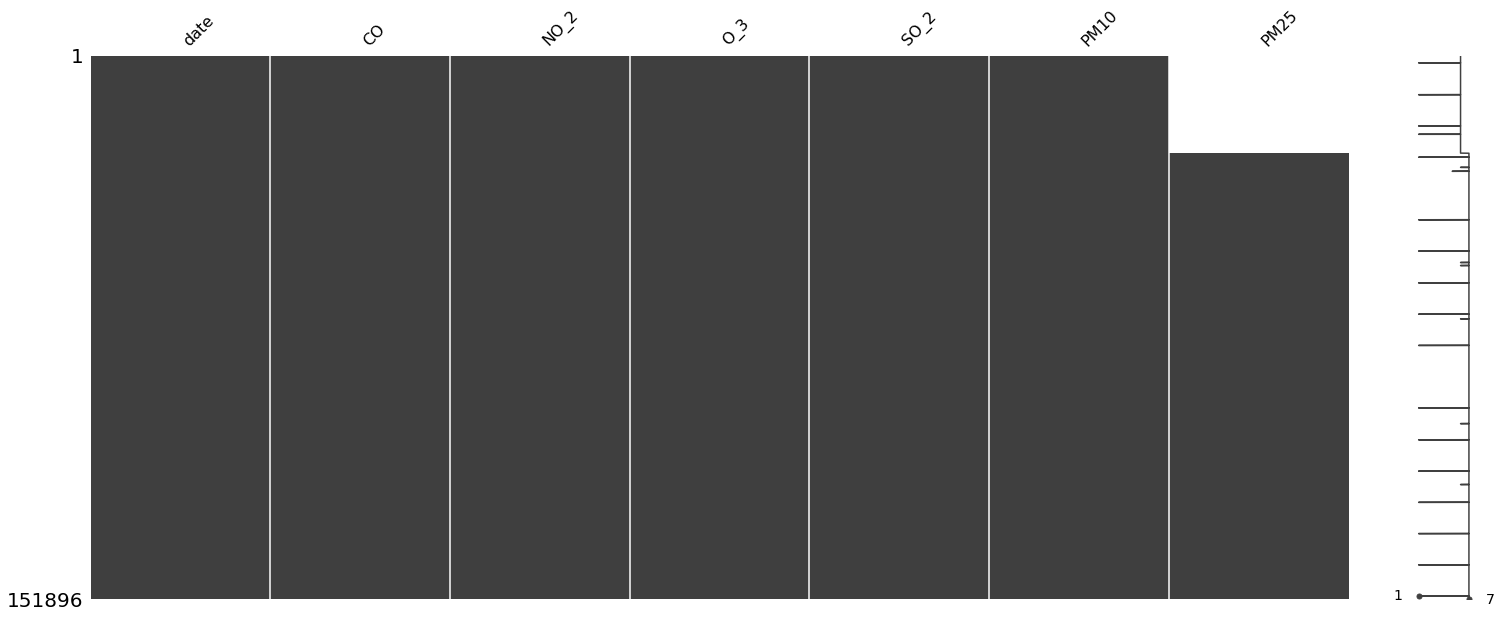

In [60]:
msno.matrix(df)

Most of the data is missing for PM25 for about starting 3-4 years. Next I will interpolate the missing data for all other pollutants but I wnat to keep the data missing for PM25 as is

In [61]:
#function to interpolate the missing values
def interpolation_mean(df,column_name):
    
    #the function takes in data frame and column names
    
    #checking if the column name is pm25
    if column_name != 'PM25':
        
        #if pllutant is not pm25 then I take the mean of the last and the next recoreded value 
        df[column_name] =  pd.concat([df[column_name].ffill(), df[column_name].bfill()]).groupby(level=0).mean()
        
    else:
        
        #if it is pm25 I do the same interpolation as above but fill the first 4 year missing values as NaN
        first_non_nan = df['PM25'].first_valid_index()

        df[column_name] =  pd.concat([df[column_name].ffill(), df[column_name].bfill()]).groupby(level=0).mean()
        
        df[column_name][0:first_non_nan] = np.nan

    
    return df

In [62]:
#using interpolating function
for column in df.columns[1:]:
    df = interpolation_mean(df,column)

<ipython-input-61-ff5dbafe14dd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name][0:first_non_nan] = np.nan


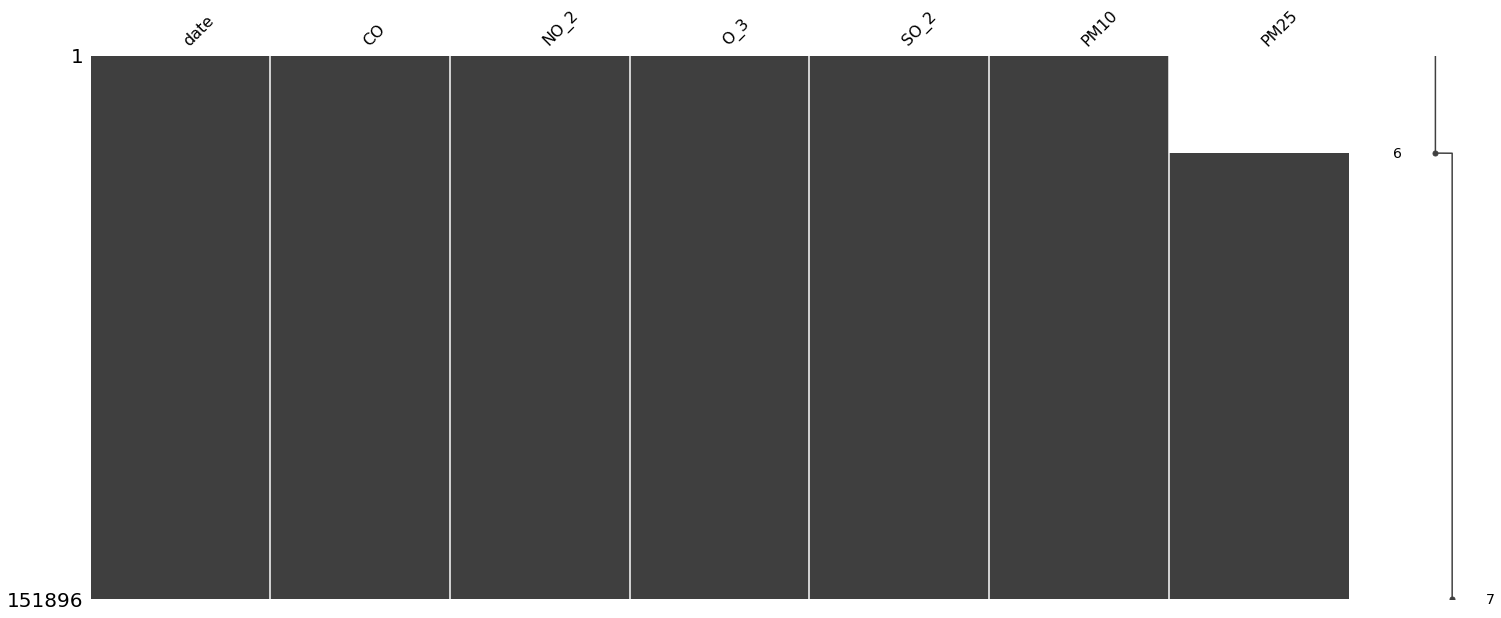

In [63]:
msno.matrix(df)

As we can see now the interpolation worked and we can now visualise the data in the next notebook

In [64]:
df.head()

,date,CO,NO_2,O_3,SO_2,PM10,PM25
0,2001-01-01 01:00:00,1.2568,55.287601,7.8292,22.1004,30.660417,NaN
1,2001-01-01 02:00:00,2.2696,55.848400,7.0744,24.0064,41.035909,NaN
2,2001-01-01 03:00:00,2.3544,55.720800,6.8332,25.4832,56.345218,NaN
3,2001-01-01 04:00:00,2.0456,56.596800,7.1856,23.6180,47.972083,NaN
4,2001-01-01 05:00:00,1.4376,53.827600,7.9592,20.0304,36.637083,NaN


In [65]:
df.to_csv('air_pollution.csv',index=False)